Epoch 50/50: 100%|██████████| 391/391 [00:00<00:00, 685.26it/s]


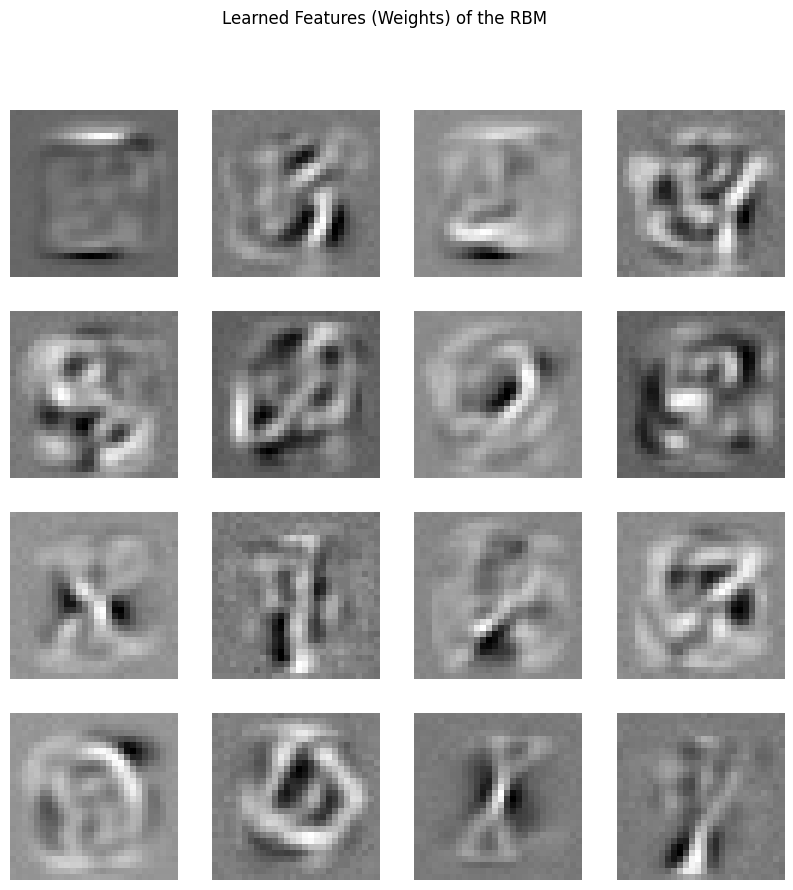

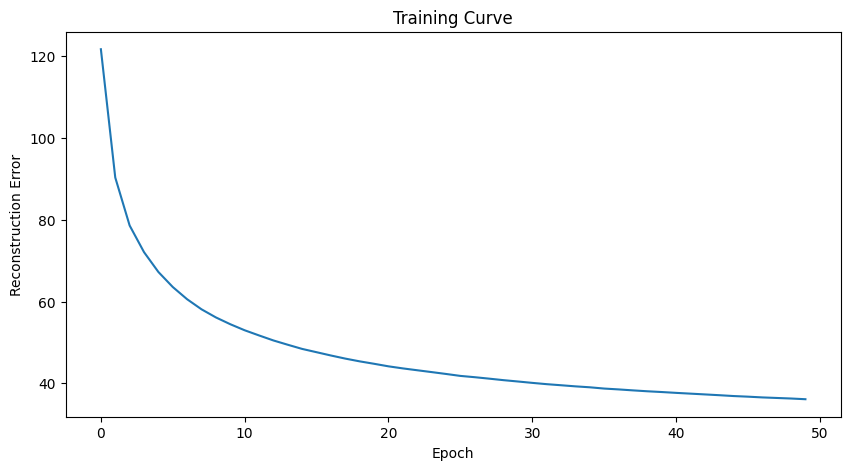

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.datasets import fetch_openml
import logging
from tqdm import tqdm
import time

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

class RestrictedBoltzmannMachine:
    def __init__(self, num_visible, num_hidden):
        """Initialize RBM with GPU support"""
        self.num_visible = num_visible
        self.num_hidden = num_hidden

        # Check if GPU is available
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        logger.info(f"Using device: {self.device}")

        # Initialize weights and biases on GPU
        self.W = torch.randn(num_visible, num_hidden, device=self.device) * 0.01
        self.b = torch.zeros(num_hidden, device=self.device)
        self.c = torch.zeros(num_visible, device=self.device)

        # Initialize loss history
        self.reconstruction_errors = []

    def sigmoid(self, x):
        """Sigmoid activation function"""
        return 1 / (1 + torch.exp(-x))

    def sample_h_given_v(self, v):
        """Sample hidden units given visible units"""
        h_prob = self.sigmoid(torch.mm(v, self.W) + self.b)
        h_sample = (h_prob > torch.rand_like(h_prob)).float()
        return h_sample, h_prob

    def sample_v_given_h(self, h):
        """Sample visible units given hidden units"""
        v_prob = self.sigmoid(torch.mm(h, self.W.t()) + self.c)
        v_sample = (v_prob > torch.rand_like(v_prob)).float()
        return v_sample, v_prob

    def gibbs_sample(self, v):
        """Perform one step of Gibbs sampling"""
        h_sample, _ = self.sample_h_given_v(v)
        v_sample, _ = self.sample_v_given_h(h_sample)
        return v_sample, h_sample

    def free_energy(self, v):
        """Calculate free energy"""
        vbias_term = torch.mv(v, self.c)
        wx_b = torch.mm(v, self.W) + self.b
        hidden_term = torch.sum(torch.log(1 + torch.exp(wx_b)), dim=1)
        return -hidden_term - vbias_term

    def train(self, train_data, batch_size=100, epochs=10, lr=0.1):
        """Train the RBM using mini-batch CD-1"""
        logger.info("Starting training...")
        start_time = time.time()

        # Convert numpy array to PyTorch tensor and move to GPU
        train_tensor = torch.FloatTensor(train_data).to(self.device)

        # Create data loader
        train_loader = torch.utils.data.DataLoader(
            train_tensor,
            batch_size=batch_size,
            shuffle=True
        )

        num_batches = len(train_loader)

        for epoch in range(epochs):
            epoch_error = 0
            epoch_start = time.time()

            # Use tqdm for progress bar
            for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
                batch = batch.to(self.device)

                # Positive phase
                h_pos, h_pos_prob = self.sample_h_given_v(batch)

                # Negative phase
                v_neg, _ = self.sample_v_given_h(h_pos)
                h_neg, _ = self.sample_h_given_v(v_neg)

                # Calculate gradients
                pos_associations = torch.mm(batch.t(), h_pos_prob)
                neg_associations = torch.mm(v_neg.t(), h_neg)

                # Update weights and biases
                self.W += lr * (pos_associations - neg_associations) / batch_size
                self.b += lr * torch.mean(h_pos - h_neg, dim=0)
                self.c += lr * torch.mean(batch - v_neg, dim=0)

                # Calculate reconstruction error
                batch_error = torch.mean(torch.sum((batch - v_neg)**2, dim=1))
                epoch_error += batch_error.item()

            # Log epoch statistics
            epoch_error /= num_batches
            epoch_time = time.time() - epoch_start
            self.reconstruction_errors.append(epoch_error)

            logger.info(f"Epoch {epoch+1}/{epochs} - "
                       f"Error: {epoch_error:.4f} - "
                       f"Time: {epoch_time:.2f}s")

        total_time = time.time() - start_time
        logger.info(f"Training completed in {total_time:.2f} seconds")

    def evaluate(self, test_data):
        """Evaluate the RBM's performance"""
        logger.info("Starting evaluation...")

        with torch.no_grad():
            test_tensor = torch.FloatTensor(test_data).to(self.device)
            v_rec, _ = self.gibbs_sample(test_tensor)
            error = torch.mean((test_tensor - v_rec)**2).item()

        logger.info(f"Test Reconstruction Error: {error:.4f}")
        return error

    def visualize_features(self, save_path=None):
        """Visualize the learned features"""
        plt.figure(figsize=(10, 10))

        # Move weights to CPU for visualization
        W = self.W.cpu().numpy()

        # Plot first 16 features
        for i in range(16):
            plt.subplot(4, 4, i + 1)
            plt.imshow(W[:, i].reshape(28, 28), cmap='gray')
            plt.axis('off')

        plt.suptitle("Learned Features (Weights) of the RBM")

        if save_path:
            plt.savefig(save_path)
            logger.info(f"Features visualization saved to {save_path}")

        plt.show()

    def plot_training_curve(self, save_path=None):
        """Plot the training curve"""
        plt.figure(figsize=(10, 5))
        plt.plot(self.reconstruction_errors)
        plt.title('Training Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Reconstruction Error')

        if save_path:
            plt.savefig(save_path)
            logger.info(f"Training curve saved to {save_path}")

        plt.show()

def main():
    logger.info("Starting RBM training process...")

    # Load MNIST dataset
    logger.info("Loading MNIST dataset...")
    mnist = fetch_openml('mnist_784', as_frame=False)

    # Prepare data
    train_data = mnist.data[:50000].astype(float) / 255
    test_data = mnist.data[50000:60000].astype(float) / 255
    logger.info(f"Data loaded - Training samples: {len(train_data)}, Test samples: {len(test_data)}")

    # Initialize RBM
    rbm = RestrictedBoltzmannMachine(num_visible=784, num_hidden=500)

    # Training parameters
    params = {
        'batch_size': 128,
        'epochs': 50,
        'lr': 0.01
    }
    logger.info(f"Training parameters: {params}")

    # Train the RBM
    rbm.train(train_data, **params)

    # Evaluate
    test_error = rbm.evaluate(test_data)

    # Visualize results
    rbm.visualize_features('rbm_features.png')
    rbm.plot_training_curve('training_curve.png')

if __name__ == "__main__":
    main()

Epoch 20/20: 100%|██████████| 79/79 [00:00<00:00, 794.16it/s]


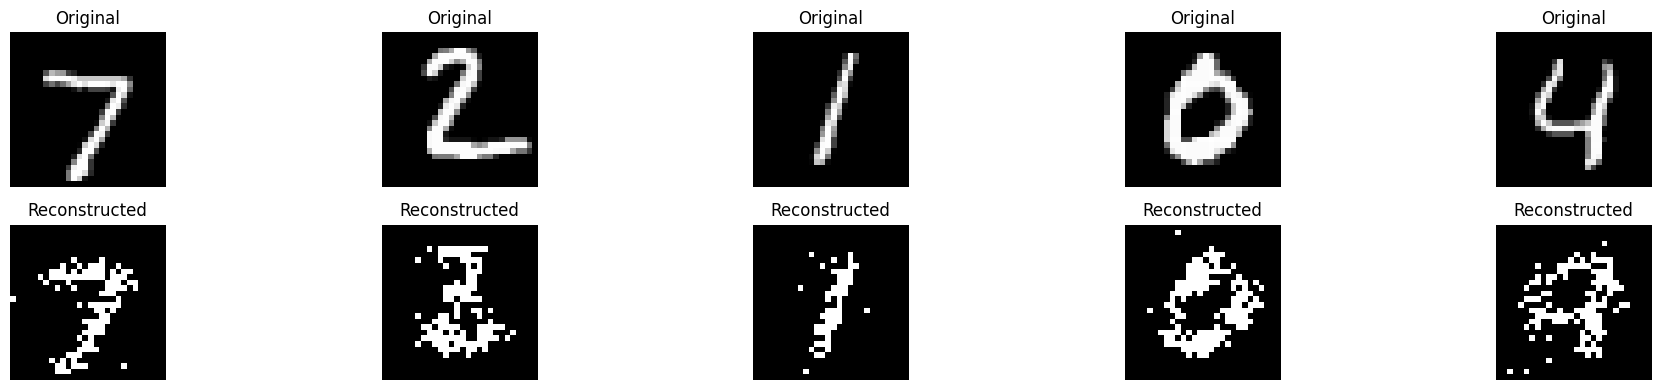

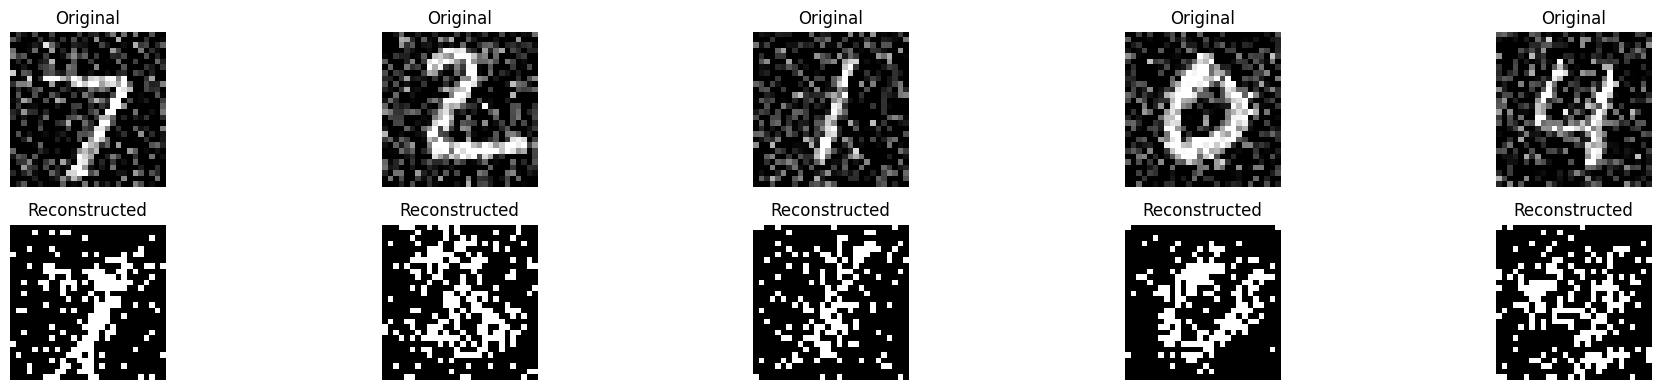

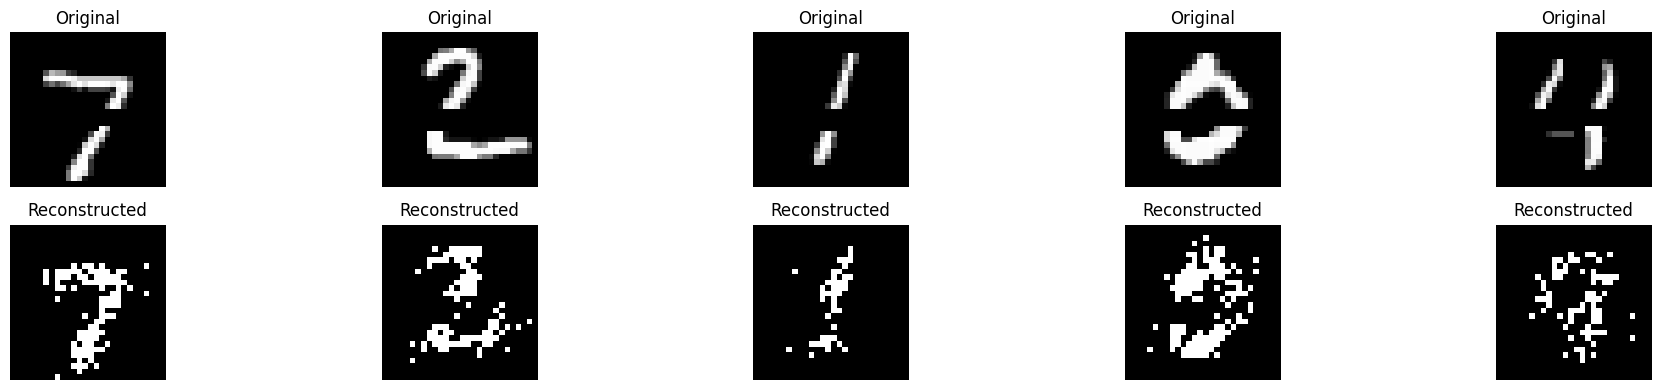

In [2]:
def reconstruct_and_visualize(rbm, input_digits, num_gibbs_steps=1):
    """
    Reconstruct input digits using the trained RBM and visualize the results

    Args:
        rbm: Trained RBM model
        input_digits: Input digit images to reconstruct
        num_gibbs_steps: Number of Gibbs sampling steps for reconstruction
    """
    logger.info("Starting digit reconstruction...")

    # Convert input to tensor and move to device
    input_tensor = torch.FloatTensor(input_digits).to(rbm.device)

    # Initialize reconstructions with input
    current_visible = input_tensor

    # Perform multiple steps of Gibbs sampling
    with torch.no_grad():
        for step in range(num_gibbs_steps):
            # Forward-backward pass
            hidden_states, _ = rbm.sample_h_given_v(current_visible)
            current_visible, visible_probs = rbm.sample_v_given_h(hidden_states)

    # Move tensors back to CPU for visualization
    original_images = input_digits
    reconstructed_images = current_visible.cpu().numpy()

    # Plotting
    num_digits = len(input_digits)
    plt.figure(figsize=(20, 4))

    # Plot original images
    for i in range(num_digits):
        plt.subplot(2, num_digits, i + 1)
        plt.imshow(original_images[i].reshape(28, 28), cmap='gray')
        plt.title('Original')
        plt.axis('off')

    # Plot reconstructed images
    for i in range(num_digits):
        plt.subplot(2, num_digits, num_digits + i + 1)
        plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def add_noise(images, noise_factor=0.3):
    """Add random noise to images"""
    noisy_images = images.copy()
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=images.shape)
    noisy_images = noisy_images + noise
    return np.clip(noisy_images, 0.0, 1.0)

def test_recognition():
    logger.info("Starting RBM recognition test...")

    # Load MNIST dataset
    mnist = fetch_openml('mnist_784', as_frame=False)

    # Prepare test data
    test_data = mnist.data[60000:60010].astype(float) / 255  # Take 10 test images
    test_labels = mnist.target[60000:60010]
    logger.info(f"Test data shape: {test_data.shape}")

    # Initialize and train RBM
    rbm = RestrictedBoltzmannMachine(num_visible=784, num_hidden=500)

    # Training parameters
    params = {
        'batch_size': 128,
        'epochs': 20,  # Reduced epochs for demonstration
        'lr': 0.01
    }

    # Train on the first 10000 samples for demonstration
    train_data = mnist.data[:10000].astype(float) / 255
    logger.info("Training RBM on subset of data...")
    rbm.train(train_data, **params)

    # Test 1: Basic Reconstruction
    logger.info("Testing basic reconstruction...")
    reconstruct_and_visualize(rbm, test_data[:5])

    # Test 2: Reconstruction with Noise
    logger.info("Testing reconstruction with noise...")
    noisy_test_data = add_noise(test_data[:5])
    reconstruct_and_visualize(rbm, noisy_test_data)

    # Test 3: Reconstruction with Partial Occlusion
    logger.info("Testing reconstruction with occlusion...")
    occluded_test_data = test_data[:5].copy()
    # Create a rectangular occlusion in the middle of each image
    occluded_test_data[:, 392:492] = 0  # Occlude middle portion
    reconstruct_and_visualize(rbm, occluded_test_data)

    # Calculate and log reconstruction errors for each test
    with torch.no_grad():
        # Original data reconstruction error
        original_error = rbm.evaluate(test_data[:5])
        logger.info(f"Original data reconstruction error: {original_error:.4f}")

        # Noisy data reconstruction error
        noisy_error = rbm.evaluate(noisy_test_data)
        logger.info(f"Noisy data reconstruction error: {noisy_error:.4f}")

        # Occluded data reconstruction error
        occluded_error = rbm.evaluate(occluded_test_data)
        logger.info(f"Occluded data reconstruction error: {occluded_error:.4f}")

def main_recognition():
    """Main function for recognition testing"""
    logger.info("Starting recognition testing pipeline...")

    try:
        test_recognition()
        logger.info("Recognition testing completed successfully")
    except Exception as e:
        logger.error(f"Error during recognition testing: {str(e)}")
        raise

if __name__ == "__main__":
    main_recognition()